In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('poster')

In [5]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
df = pd.read_pickle('CCPA.pkl.gz')

In [9]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [10]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

In [11]:
d = cp.generate_decline(dfc, scale=False)

In [12]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
t0  = d.groupby(groupby_cols).get_group(('e3, 10A','e3','10A', 'C9B', 'DE', 'Co_Culture'))

In [13]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='3d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [350]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = d.groupby(groupby_cols).apply(convert_func).reset_index() 

In [351]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds[ds.day < 80]

In [352]:
ds.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,FL
0,"e3, 10A",e3,10A,C9B,DE,Co_Culture,0,3.352000
1,"e3, 10A",e3,10A,C9B,DE,Co_Culture,1,2.895500
2,"e3, 10A",e3,10A,C9B,DE,Co_Culture,2,2.789000
3,"e3, 10A",e3,10A,C9B,DE,Co_Culture,3,2.376333
4,"e3, 10A",e3,10A,C9B,DE,Co_Culture,4,1.976000


In [286]:
ds['decline'] = ds['FL']

In [17]:
t0.head()

,experiment_sample,day,FL,experiment,sample,PRO,ALT,culture
0,"e3, 10A",0.00,3.352,e3,10A,C9B,DE,Co_Culture
1,"e3, 10A",1.03,2.439,e3,10A,C9B,DE,Co_Culture
2,"e3, 10A",2.14,2.576,e3,10A,C9B,DE,Co_Culture
3,"e3, 10A",3.10,2.114,e3,10A,C9B,DE,Co_Culture
4,"e3, 10A",4.09,1.238,e3,10A,C9B,DE,Co_Culture


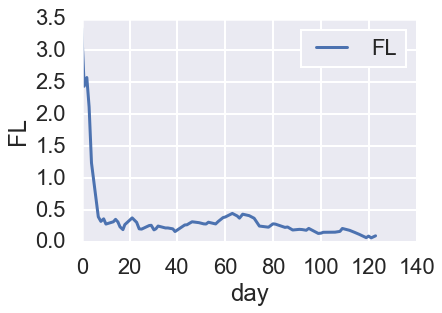

In [16]:
sns.lineplot(data=t0, x='day', y='FL', label='FL')
sns.lineplot(data=t0, x='day', y='FL', label='FL')


In [18]:
t0.shape

(70, 8)

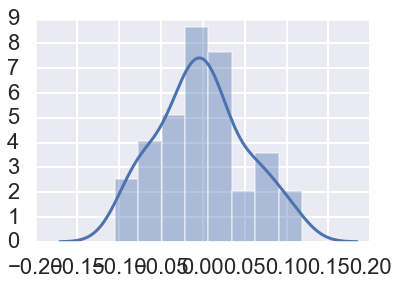

In [73]:
noise = np.random.normal(size=70, scale=0.05)
sns.distplot(noise, )

In [79]:
t1 = cp._augment_func(t0, augment_col='FL', scale=0.05)
t2 = cp._augment_func(t0, augment_col='day', scale=0.5, keep_monotone=True)

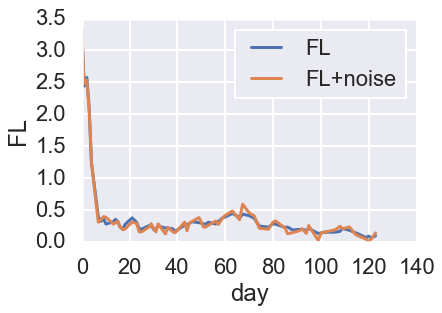

In [80]:
sns.lineplot(data=t0, x='day', y='FL', label='FL')
sns.lineplot(data=t1, x='day', y='FL', label='FL+noise')
#sns.lineplot(data=t2, x='dayn', y='FL', label='day+noise')


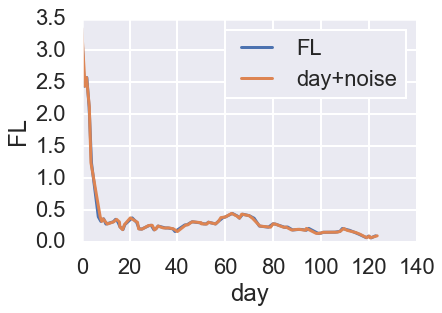

In [81]:
sns.lineplot(data=t0, x='day', y='FL', label='FL')
#sns.lineplot(data=t1, x='day', y='FL', label='FL+noise')
sns.lineplot(data=t2, x='day', y='FL', label='day+noise')


In [86]:
funcs = ['mean', 'median', 'min', 'max', 'first', 'last']
augmented_t0 = [cp._resample_func(t0, value_col='FL', period='1d', func=f) for f in funcs]
augmented_t1 = [cp._resample_func(t1, value_col='FL', period='1d', func=f) for f in funcs]
augmented_t2 = [cp._resample_func(t2, value_col='FL', period='1d', func=f) for f in funcs]


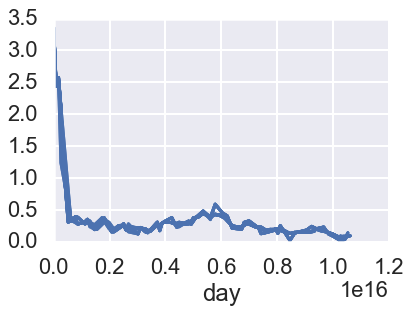

In [87]:
for f,i in zip(funcs,augmented_t0):
    sns.lineplot(data=i, label = f, legend=False)
for f,i in zip(funcs,augmented_t1):
    sns.lineplot(data=i, label = f, legend=False)
for f,i in zip(funcs,augmented_t2):
    sns.lineplot(data=i, label = f, legend=False)

In [84]:
augmented_t0[0].head()

,FL
day,
0 days,3.352
1 days,2.439
2 days,2.576
3 days,2.114
4 days,1.238


In [376]:
dfe = dfe.loc[dfe.experiment_sample != 'e5, 11C' ]

In [377]:
dfe.isna().sum()

day                  0
experiment_sample    0
experiment           0
PRO                  0
ALT                  0
sample               0
culture              0
FL                   0
exponential          0
popt_0               0
popt_1               0
popt_2               0
decline              0
exponential_diff     0
diff_norm            0
dtype: int64

In [355]:
n = 'exponential'
f = cp.model_exponential
dfe = ds.loc[:, ['day', 'experiment_sample', 'experiment', 'PRO', 'ALT', 'sample', 'culture', 'FL']]
t = dfe.groupby('experiment_sample').apply(lambda x: cp.apply_fit(x, f))
dfe[n] = t['y_pred']
for i in range(3):
    dfe[f'popt_{i}'] = t[f'popt_{i}']
dfe['decline'] = dfe.FL
dfe['exponential_diff'] = dfe.FL - dfe.exponential
#dfe['decline_scaled'] = dfe.groupby('experiment_sample').FL.transform(lambda x: x / x.max())
#df_exp_coef = dfe.groupby(['experiment_sample','popt_0', 'popt_1', 'popt_2'])['decline'].count().reset_index(level=[1,2,3])\
#.drop(columns='decline')

[3.44777422 0.27725538 0.28136652 1.        ]
[3.44777422 0.27725538 0.28136652 1.        ]
[3.49365944 0.27655572 0.25267615 1.        ]
[3.32550832 0.2966611  0.26695942 1.        ]
[1.59688654 0.04532469 0.21236318 1.        ]
[2.82671644 0.07208449 0.14413437 1.        ]
[ 1.53361336  0.0271304  -0.02804985  1.        ]
[0.69413831 0.21316518 0.05534486 1.        ]
[0.70845871 0.21578624 0.058052   1.        ]
[0.88445328 0.13165346 0.08839416 1.        ]
[2.25310482 0.11554809 0.42827202 1.        ]
[2.15194877 0.0756738  0.37702229 1.        ]
[2.36543588 0.09828286 0.39145624 1.        ]
[1.37169513 0.14572663 0.40282226 1.        ]
[2.19238552 0.17118731 0.37361122 1.        ]
[1.71207241 0.12259217 0.49060731 1.        ]
[2.59741113 0.17094413 0.10955225 1.        ]
[2.47793916 0.17273576 0.09217412 1.        ]
[2.43910891 0.14169682 0.09082605 1.        ]
[1.8234436  0.04843941 0.20839928 1.        ]
[1.84243783 0.08234886 0.28484413 1.        ]
[0.58371068 0.12928614 0.07028

[4.26506232 0.30883006 0.29480565 1.        ]
[5.20698283 0.33751279 0.1729429  1.        ]
[1.7779007  0.03564223 0.04340331 1.        ]
[ 1.53894149  0.02523284 -0.05634454  1.        ]
[2.56616972 0.16215171 0.48975604 1.        ]
[4.31851396 0.26257497 0.23004413 1.        ]
[0.85790414 0.16107971 0.05000388 1.        ]
[0.73360644 0.17752791 0.04960382 1.        ]
[3.79449476 0.08294621 0.07403731 1.        ]
[3.19762525 0.18411729 0.13524065 1.        ]
[3.78345298 0.08727411 0.07573179 1.        ]
[1.39823998 0.03111997 0.00881853 1.        ]
[1.9476363  0.0501781  0.21339792 1.        ]
[3.56082294 0.14232797 0.2120412  1.        ]
[1.97550934 0.12367171 0.18852755 1.        ]
[2.18679864 0.12410952 0.17097592 1.        ]
[3.91138881 0.24073161 0.19081747 1.        ]
[ 2.54843582  0.02970906 -0.14042311  1.        ]
[2.84285297 0.0597977  0.0552021  1.        ]
[3.67534476 0.16904882 0.39885339 1.        ]
[1.34812227 0.24709984 0.13356369 1.        ]
[0.96844263 0.17944114 0.0

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


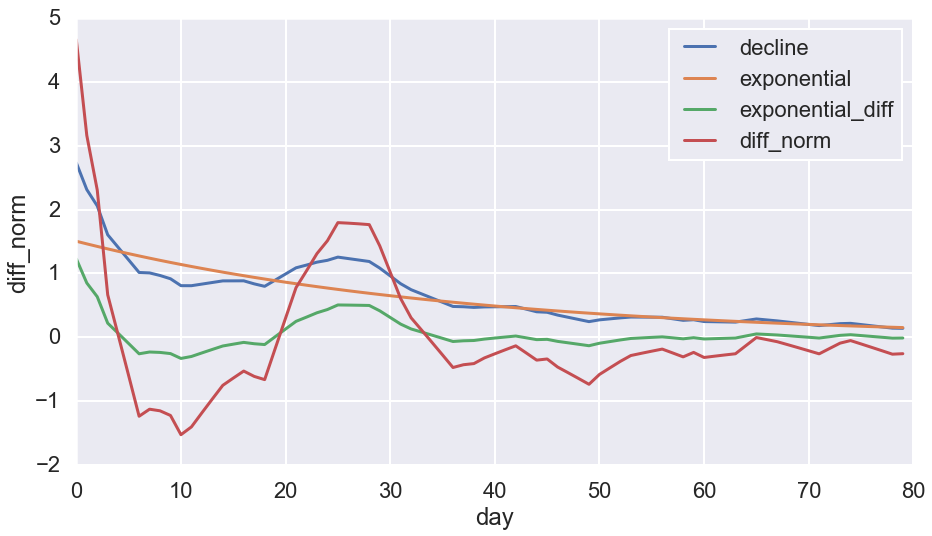

In [365]:
e = 'e3, 11C'
w = dfe.loc[dfe.experiment_sample == e]
sns.lineplot(data=w, x='day', y='decline', label='decline')
sns.lineplot(data=w, x='day', y='exponential', label='exponential')
sns.lineplot(data=w, x='day', y='exponential_diff', label='exponential_diff')
sns.lineplot(data=w, x='day', y='diff_norm', label='diff_norm')

#dfe.groupby(['experiment_sample','PRO','ALT','experiment']).day.count()

In [379]:
res, _y_list, _clf_list, _features_list = cp.compare_models(dfe, 
               value_col_list=['exponential', 'decline', 'exponential_diff', 'diff_norm', 'popt_2'], 
               resample_period_list=[None, '3d'], 
               y_col_list=['PRO','ALT', 'PRO_ALT', 'ALT_PRO'], 
               cumsummode_list=[False],
               repetitions=1,
               return_y=True)
# stats_list.extend(res)
# y_list.extend(_y_list)
# clf_list.extend(_clf_list)
# features_list.extend(_features_list)

PRO_exponential
train score 0.9068627450980392
ALT_exponential
train score 0.8774509803921569
PRO_ALT_exponential
train score 0.8970588235294118
ALT_PRO_exponential
train score 0.8774509803921569
PRO_exponential_3d
train score 0.8774509803921569
ALT_exponential_3d
train score 0.8823529411764706
PRO_ALT_exponential_3d
train score 0.8921568627450981
ALT_PRO_exponential_3d
train score 0.8578431372549019
PRO_decline
train score 0.9705882352941176
ALT_decline
train score 0.9313725490196079
PRO_ALT_decline
train score 0.9754901960784313
ALT_PRO_decline
train score 0.9901960784313726
PRO_decline_3d
train score 0.9705882352941176
ALT_decline_3d
train score 0.9803921568627451
PRO_ALT_decline_3d
train score 0.9754901960784313
ALT_PRO_decline_3d
train score 0.9754901960784313
PRO_exponential_diff
train score 1.0
ALT_exponential_diff
train score 0.9852941176470589
PRO_ALT_exponential_diff
train score 1.0
ALT_PRO_exponential_diff
train score 1.0
PRO_exponential_diff_3d
train score 0.990196078431372

In [381]:
stats_df = pd.DataFrame.from_records(res)
stats_df.fillna({'resample_period' : 'N/A'}, inplace=True)

In [382]:
stats_df.describe()

,accuracy_test,accuracy_train,f1_test,f1_train,n_features,orig_n_features,precision_test,precision_train,recall_test,recall_train
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.351923,0.904167,0.341151,0.903720,34.350000,53.500000,0.365560,0.906695,0.351923,0.904167
std,0.153972,0.126962,0.155854,0.127682,24.266205,26.837593,0.164594,0.123950,0.153972,0.126962
min,0.138462,0.588235,0.113557,0.587887,5.000000,27.000000,0.105641,0.594479,0.138462,0.588235
25%,0.242308,0.876225,0.227831,0.874609,15.000000,27.000000,0.236810,0.878924,0.242308,0.876225
50%,0.323077,0.973039,0.307394,0.973208,25.000000,53.500000,0.332550,0.974690,0.323077,0.973039
75%,0.457692,0.995098,0.445927,0.995094,55.750000,80.000000,0.461450,0.995208,0.457692,0.995098
max,0.676923,1.000000,0.679833,1.000000,80.000000,80.000000,0.731109,1.000000,0.676923,1.000000


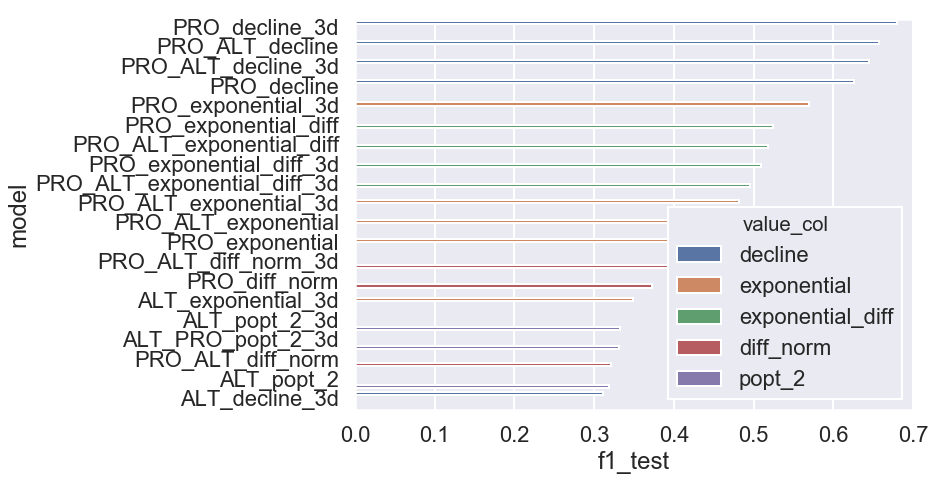

In [383]:
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x="f1_test", y="model", data=stats_df.sort_values(by="f1_test").nlargest(columns="f1_test", n=20),
            hue='value_col')

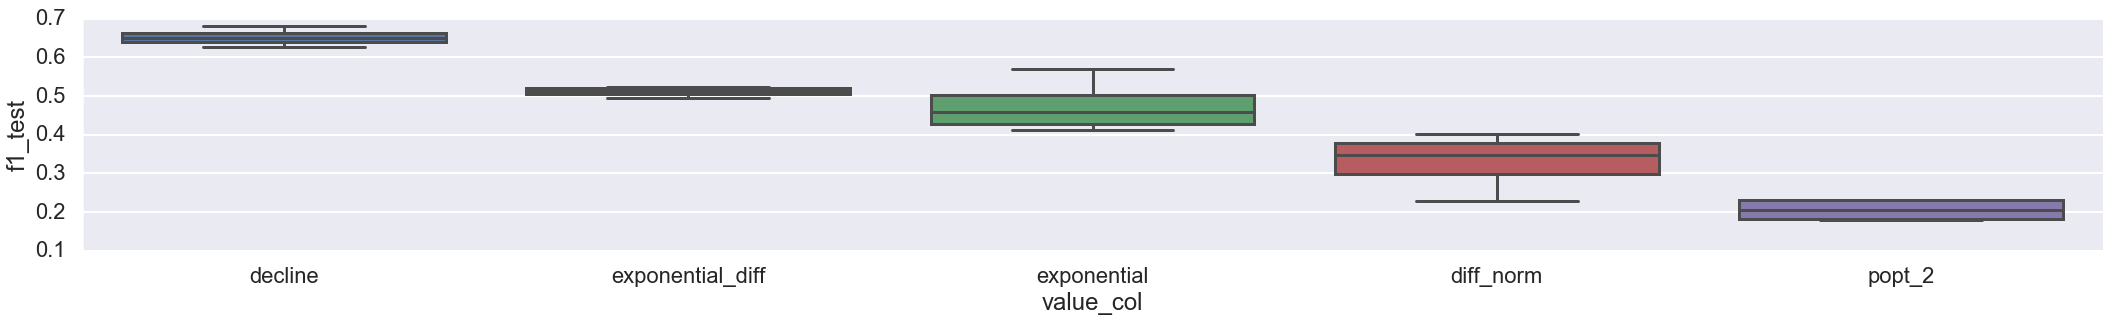

In [384]:
order = stats_df.loc[(stats_df.y_col.isin(['PRO', 'PRO_ALT'])) & (stats_df['cumsum'] == False)].groupby('value_col').f1_test.mean().sort_values(ascending=False).index
sns.catplot(data=stats_df.loc[(stats_df.y_col.isin(['PRO', 'PRO_ALT'])) & (stats_df['cumsum'] == False)], 
            x='value_col', y='f1_test', 
            #hue='resample_period', 
            #col='cumsum',
            #row='y_col', 
            aspect=6, kind='box',
            order=order,
           )

C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


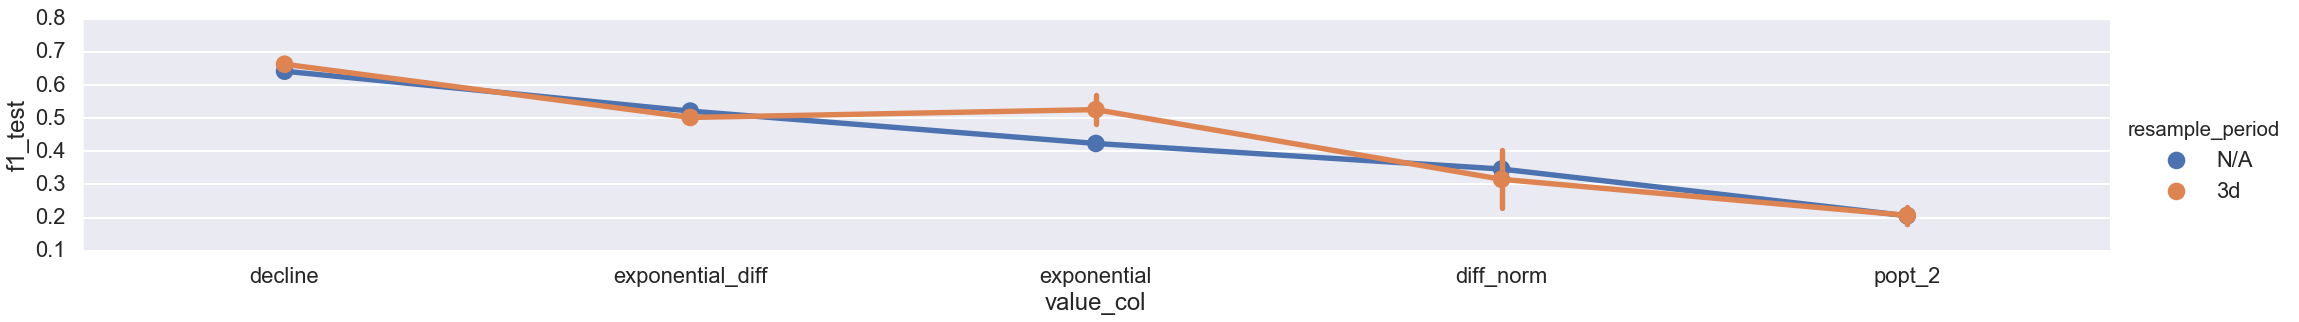

In [385]:
sns.catplot(data=stats_df.loc[stats_df.y_col.isin(['PRO', 'PRO_ALT']) & (stats_df['cumsum'] == False)], 
            x='value_col', y='f1_test', 
            hue='resample_period', 
            #col='cumsum',
            #row='y_col', 
            aspect=6, kind='point',
            order=order
           )

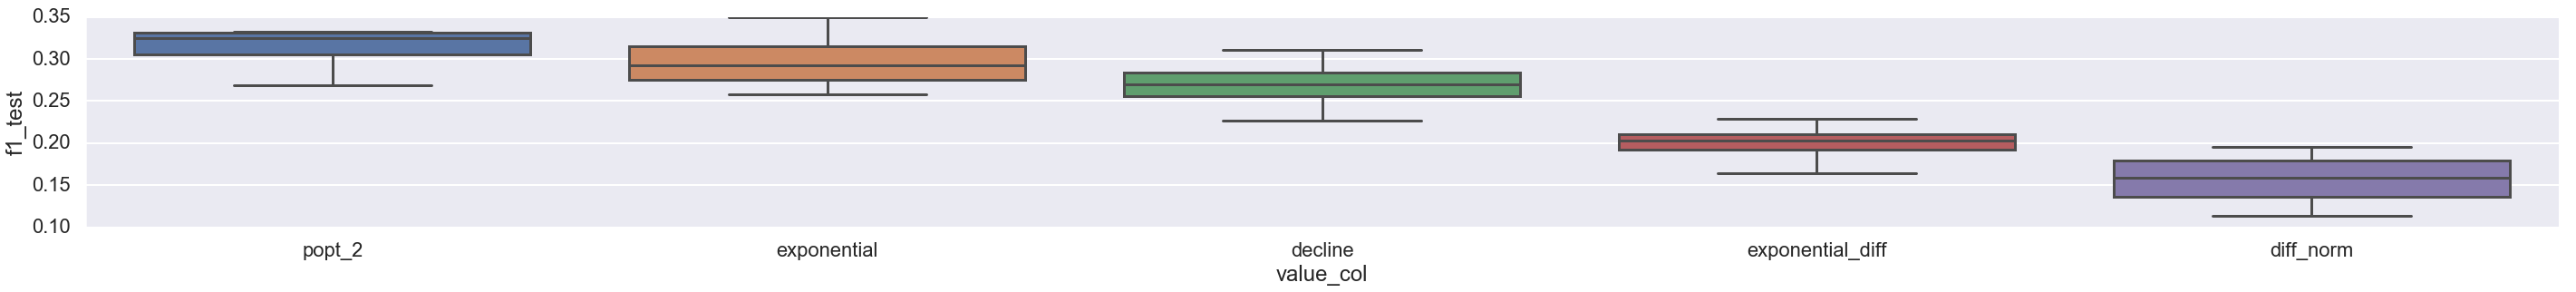

In [386]:
order = stats_df.loc[(stats_df.y_col.isin(['ALT', 'ALT_PRO'])) & (stats_df['cumsum'] == False)].groupby('value_col').f1_test.mean().sort_values(ascending=False).index
sns.catplot(data=stats_df.loc[(stats_df.y_col.isin(['ALT', 'ALT_PRO'])) & (stats_df['cumsum'] == False)], 
            x='value_col', y='f1_test', 
            #hue='resample_period', 
            #col='cumsum',
            #row='y_col', 
            aspect=8, kind='box',
            order=order,
           )

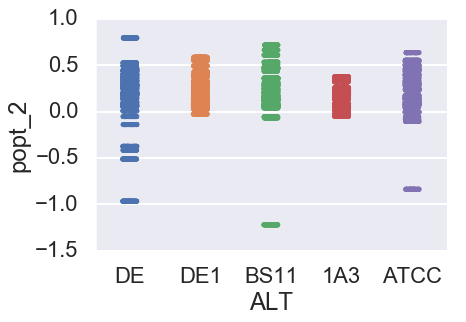

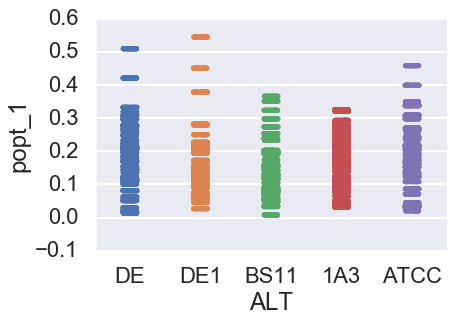

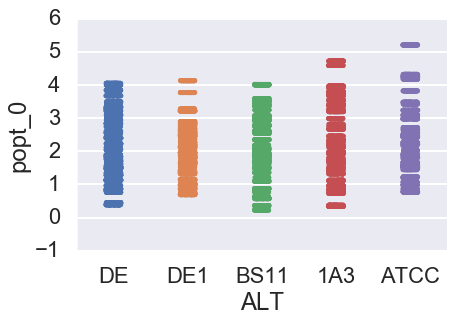

In [389]:
sns.catplot(data=dfe, x='ALT', y='popt_2', aspect=1.4)
sns.catplot(data=dfe, x='ALT', y='popt_1', aspect=1.4)
sns.catplot(data=dfe, x='ALT', y='popt_0', aspect=1.4)

In [251]:
df_exp_coef.columns[~clf.support_]

Index(['error_normal_pvalue'], dtype='object')

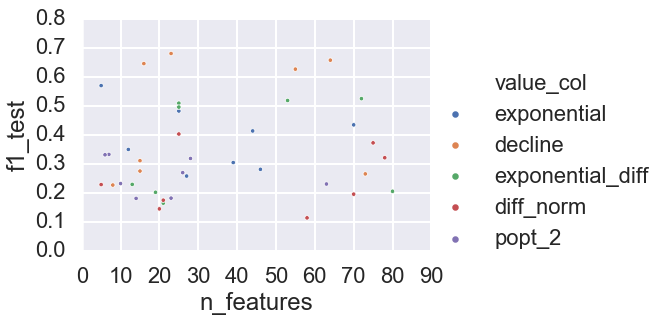

In [392]:
sns.relplot(data=stats_df, x='n_features', y='f1_test', hue='value_col', aspect=1.4)

In [398]:
stats_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       'model', 'n_features', 'orig_n_features','resample_period',
        'value_col', 'y_col']].head(10)

,f1_test,accuracy_test,accuracy_train,model,n_features,orig_n_features,resample_period,value_col,y_col
12,0.679833,0.676923,0.970588,PRO_decline_3d,23,27,3d,decline,PRO
10,0.656923,0.661538,0.985294,PRO_ALT_decline,64,80,N/A,decline,PRO_ALT
14,0.645104,0.646154,0.985294,PRO_ALT_decline_3d,16,27,3d,decline,PRO_ALT
8,0.625996,0.630769,0.970588,PRO_decline,55,80,N/A,decline,PRO
4,0.569305,0.584615,0.877451,PRO_exponential_3d,5,27,3d,exponential,PRO
16,0.524308,0.538462,1.000000,PRO_exponential_diff,72,80,N/A,exponential_diff,PRO
18,0.518006,0.523077,1.000000,PRO_ALT_exponential_diff,53,80,N/A,exponential_diff,PRO_ALT
20,0.508632,0.523077,0.990196,PRO_exponential_diff_3d,25,27,3d,exponential_diff,PRO
22,0.495182,0.507692,0.995098,PRO_ALT_exponential_diff_3d,25,27,3d,exponential_diff,PRO_ALT
6,0.481790,0.492308,0.936275,PRO_ALT_exponential_3d,25,27,3d,exponential,PRO_ALT


In [395]:
stats_df.columns

Index(['accuracy_test', 'accuracy_train', 'cumsum', 'f1_test', 'f1_train',
       'model', 'n_features', 'orig_n_features', 'precision_test',
       'precision_train', 'recall_test', 'recall_train', 'resample_period',
       'support_test', 'support_train', 'value_col', 'y_col'],
      dtype='object')

In [399]:
res[]

{'model': 'PRO_decline_3d',
 'n_features': 23,
 'orig_n_features': 27,
 'accuracy_train': 0.9705882352941176,
 'precision_train': 0.9715365636276684,
 'recall_train': 0.9705882352941176,
 'f1_train': 0.9705221503704057,
 'support_train': None,
 'accuracy_test': 0.676923076923077,
 'precision_test': 0.7311088911088911,
 'recall_test': 0.676923076923077,
 'f1_test': 0.6798328457275827,
 'support_test': None,
 'value_col': 'decline',
 'resample_period': '3d',
 'y_col': 'PRO',
 'cumsum': False}

In [400]:
idx = 12
y_df =  _y_list[idx]
clf = _clf_list[idx]
features = _features_list[idx]

In [402]:
y_df.head()

,PRO_decline_3d_y,PRO_decline_3d_y_PRO,PRO_decline_3d_y_pred,PRO_decline_3d_y_pred_PRO,Type
experiment_sample,,,,,
"e3, 10A",C9B,C9B,C9B,C9B,Train
"e3, 10B",C9B,C9B,C9B,C9B,Train
"e3, 10C",C9B,C9B,C9B,C9B,Train
"e3, 11A",MED4,MED4,MED4,MED4,Train
"e3, 11B",MED4,MED4,MED4,MED4,Train


accuracy: 0.8996282527881041
              precision    recall  f1-score   support

         C9B       0.94      0.98      0.96        51
        MED4       0.77      0.84      0.80        51
     MIT9312       0.87      0.86      0.86        56
     MIT9313       0.96      1.00      0.98        52
      Natl2A       0.96      0.83      0.89        59

   micro avg       0.90      0.90      0.90       269
   macro avg       0.90      0.90      0.90       269
weighted avg       0.90      0.90      0.90       269



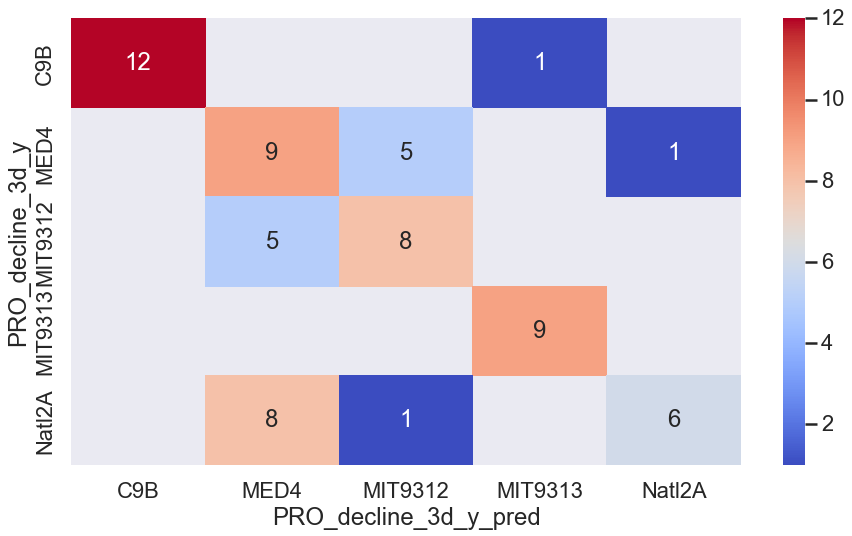

In [407]:
    from sklearn.metrics import classification_report, accuracy_score
    
    t = y_df.loc[y_df.Type == 'Test'].pivot_table(index='PRO_decline_3d_y', columns=['PRO_decline_3d_y_pred'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_decline_3d_y'], y_pred=y_df['PRO_decline_3d_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_decline_3d_y'], y_pred=y_df['PRO_decline_3d_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


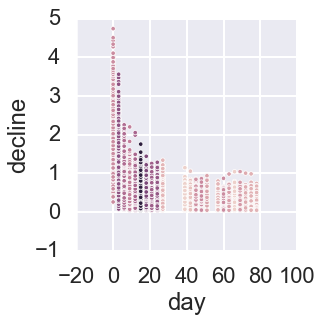

In [548]:
feature_importances = pd.DataFrame(clf.estimator_.feature_importances_,
                                   index = features[clf.support_],
                                    columns=['importance'])
mergedf = dfe.merge(feature_importances, left_on='day', right_index=True, how='left')
mergedf.head()
sns.relplot(data=mergedf, x='day', y='decline', hue='importance', legend=None)

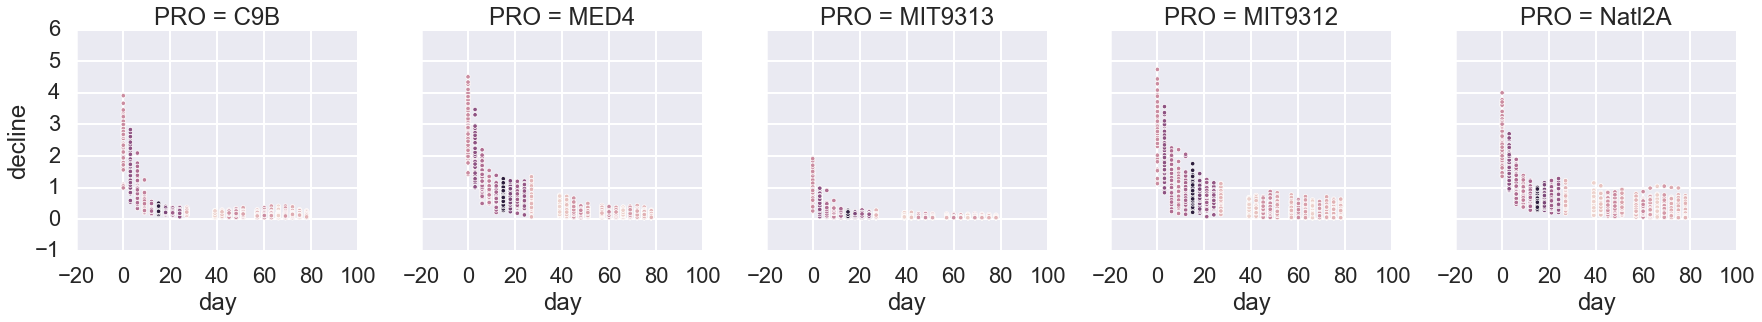

In [549]:
sns.relplot(data=mergedf, x='day', y='decline', hue='importance', legend=None, col='PRO')

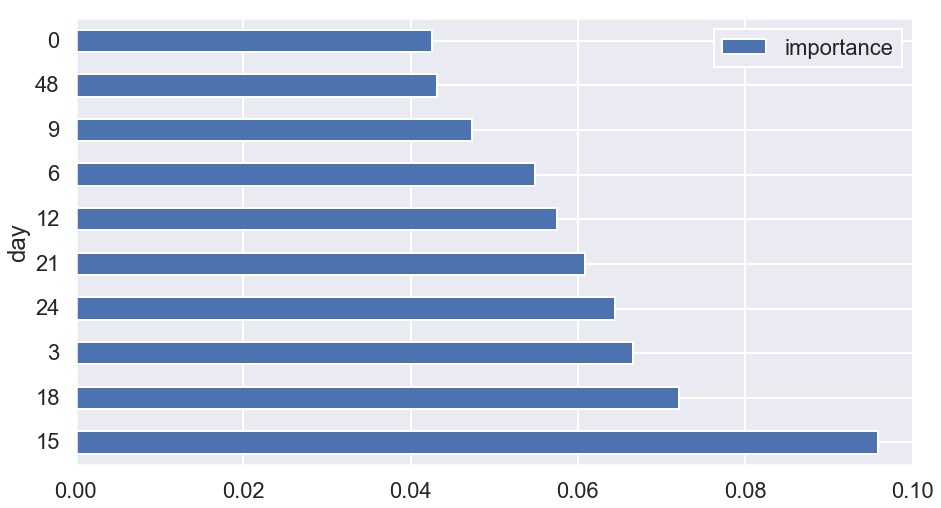

In [550]:
cp.forest_feature_importance(clf.estimator_, features[clf.support_])

# cluster by decline

In [529]:
value_col = 'decline'

In [537]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(dfe_resample3, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(dfe)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.65201678 0.17851987]


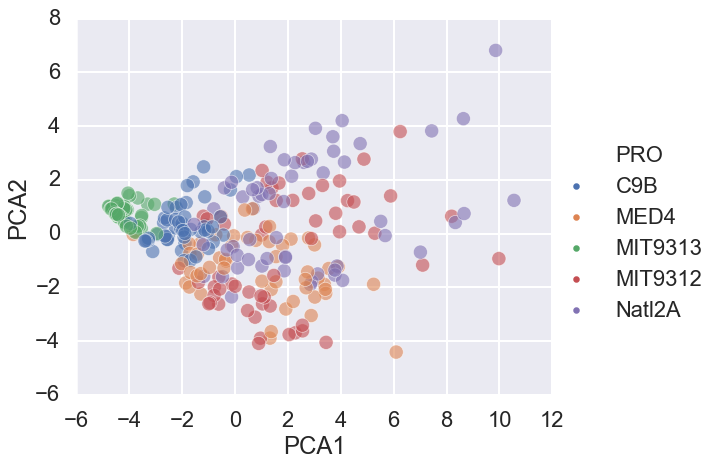

In [538]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

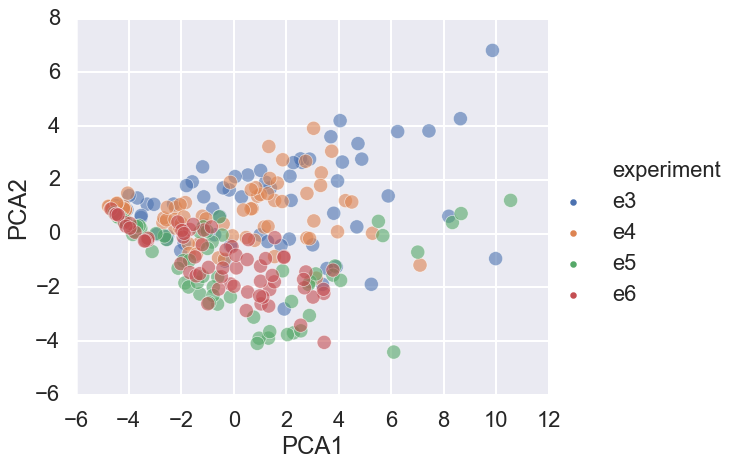

In [544]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

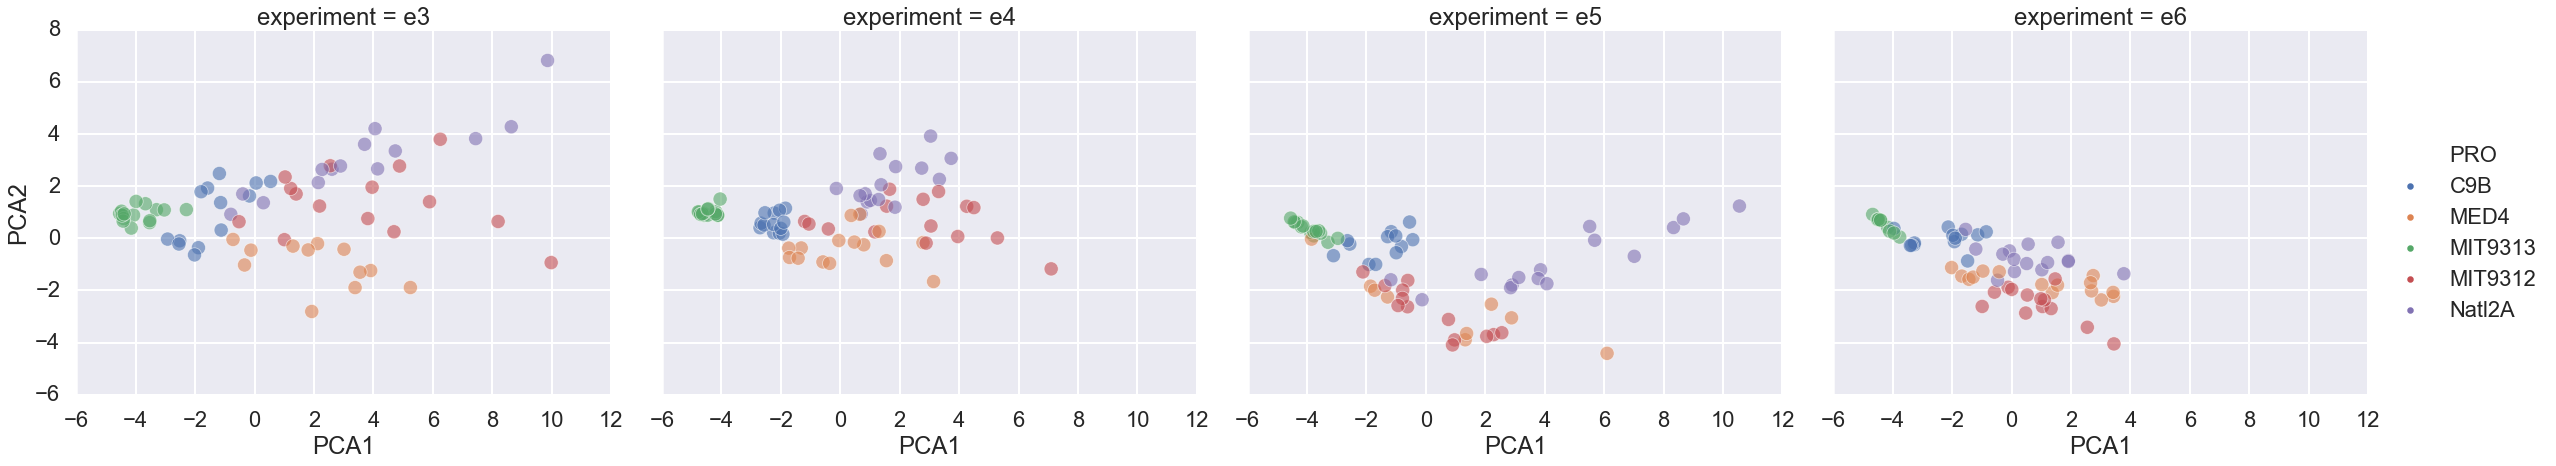

In [539]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

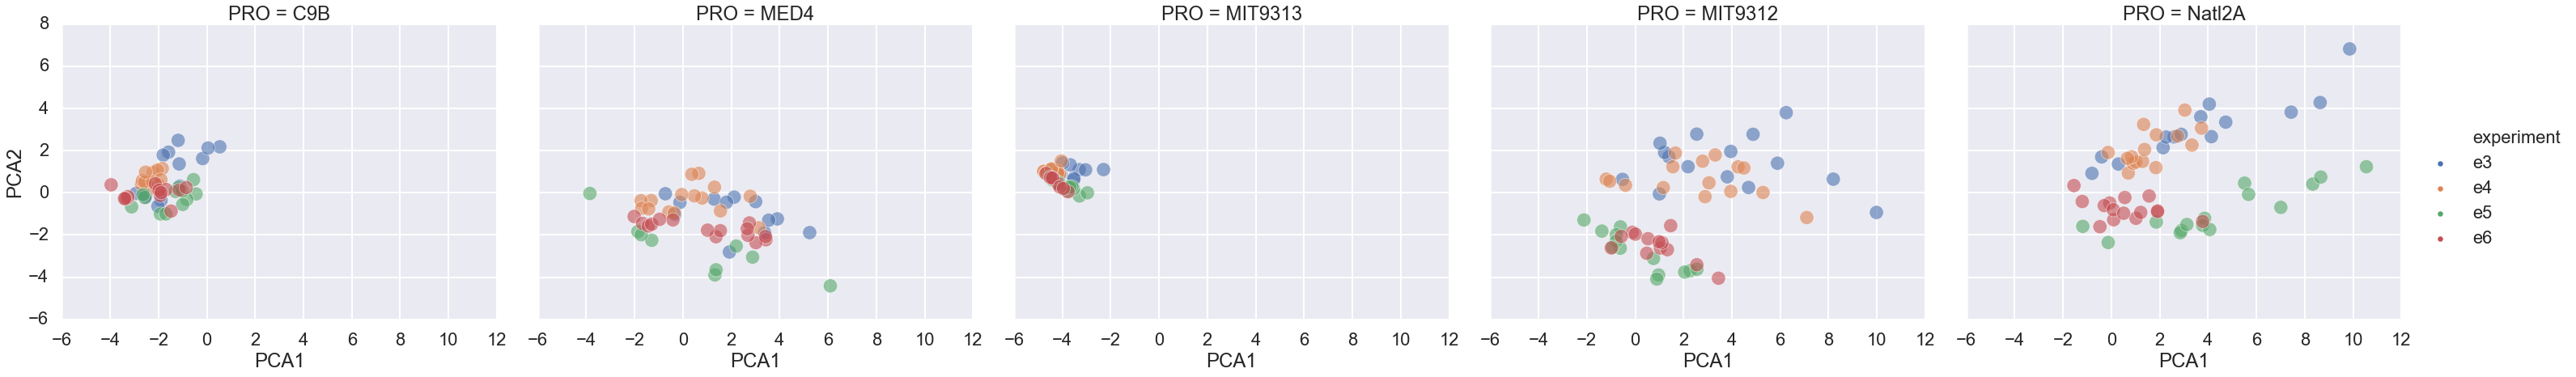

In [551]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=300, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

In [540]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


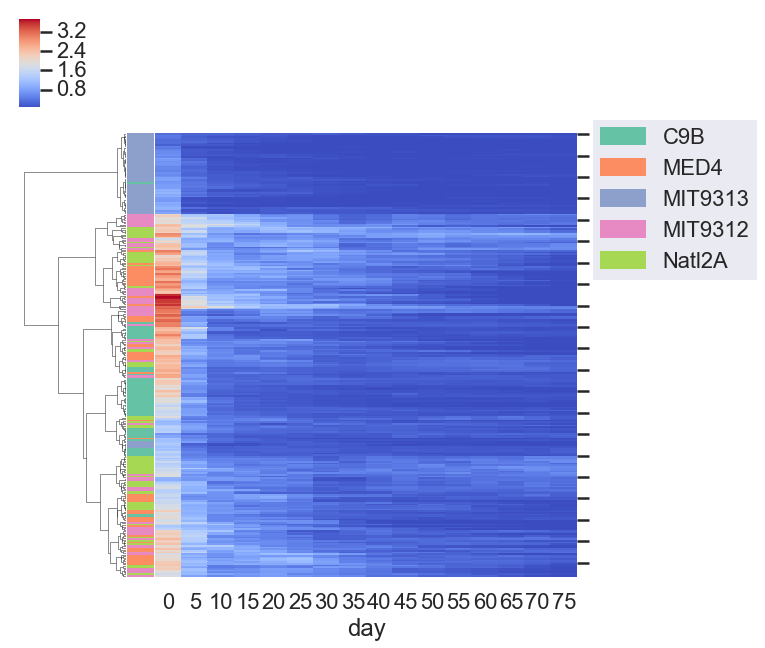

In [541]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

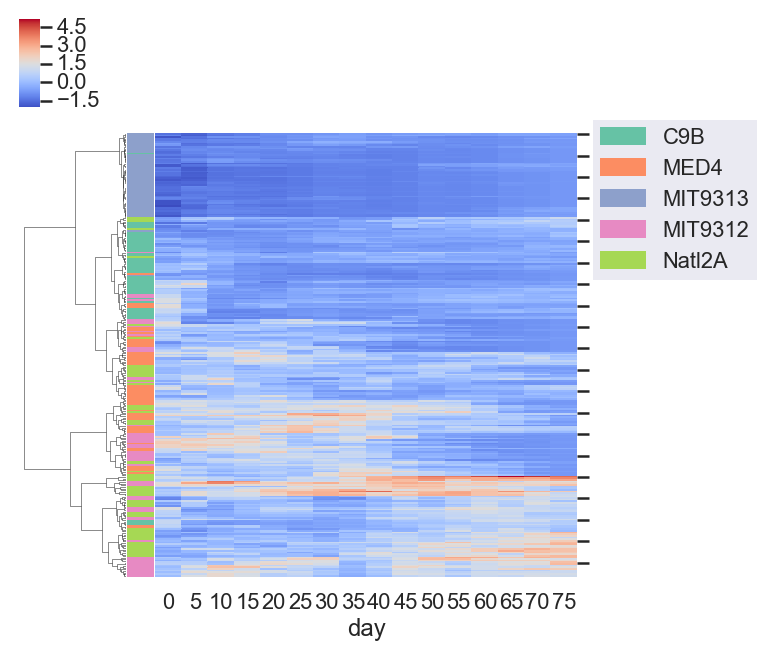

In [542]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=1
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [536]:
X.index

Index(['e3, 10A', 'e3, 10B', 'e3, 10C', 'e3, 11A', 'e3, 11B', 'e3, 11C',
       'e3, 12A', 'e3, 12B', 'e3, 12C', 'e3, 13A',
       ...
       'e6, 6B', 'e6, 6C', 'e6, 7A', 'e6, 7C', 'e6, 8A', 'e6, 8B', 'e6, 8C',
       'e6, 9A', 'e6, 9B', 'e6, 9C'],
      dtype='object', name='experiment_sample', length=269)

# cluster by exponential

In [553]:
value_col='exponential'

In [554]:
X = dfe.groupby(['experiment_sample','popt_0', 'popt_1', 'popt_2'])['decline'].count().reset_index(level=[1,2,3])\
.drop(columns='decline')

In [557]:
dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='3d')
X = cp.experiments2X(dfe_resample3, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(dfe)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Variance percent explained
 [0.77191076 0.15905594]


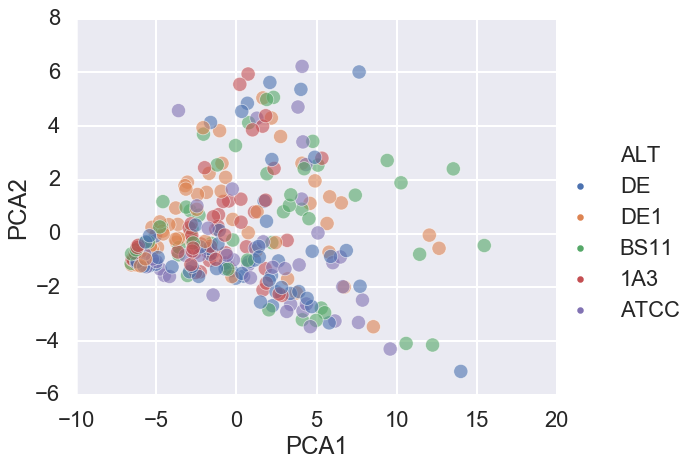

In [558]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

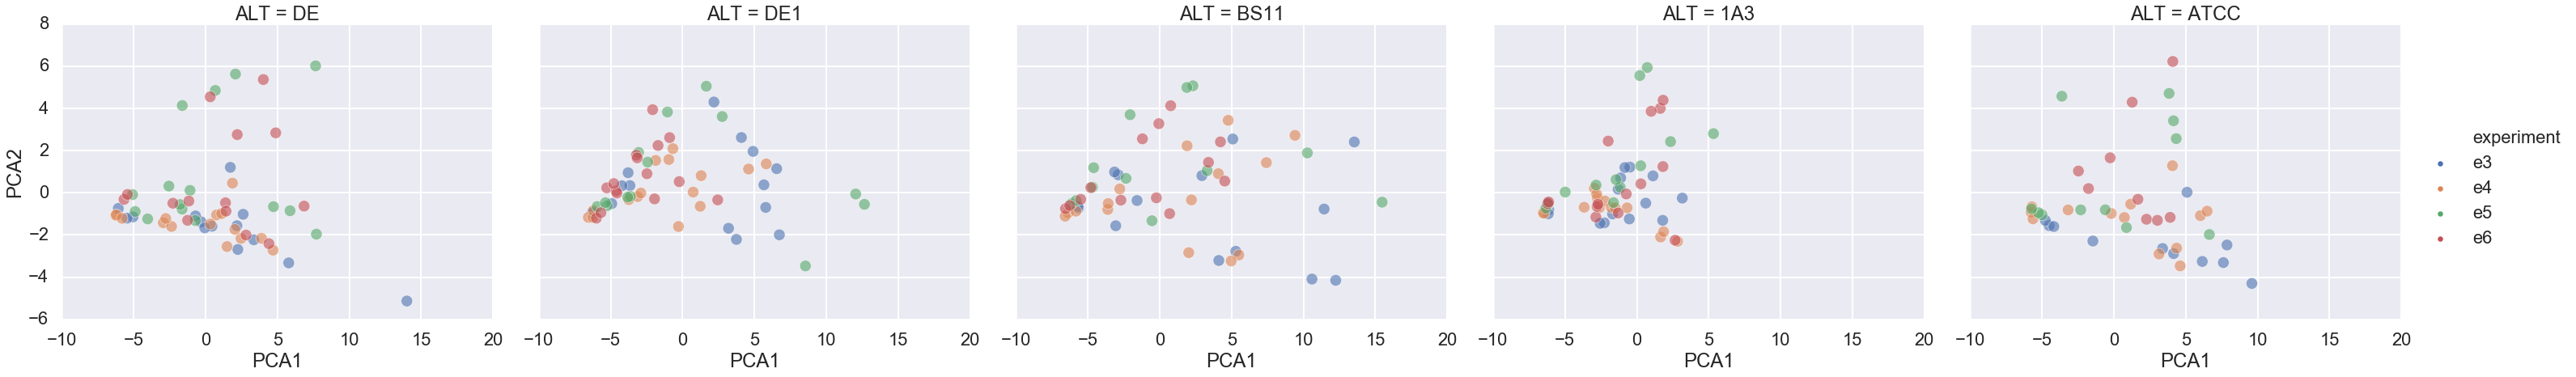

In [561]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='ALT', hue='experiment',
            #style='ALT',
            s=200, alpha=0.6, height=7, aspect=1.2,
            #palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

In [562]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'ALT'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


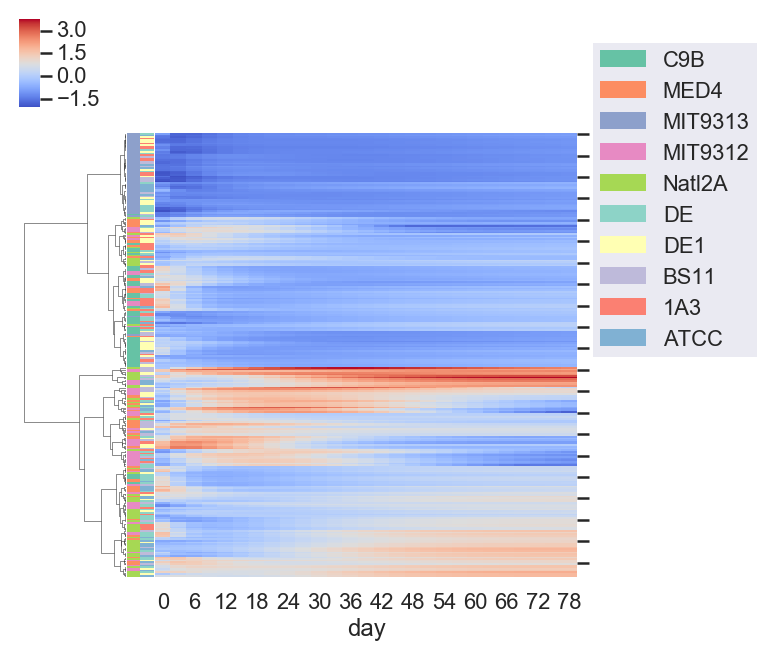

In [563]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward',
                   z_score=1,
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [515]:
X.head()

day,0,3,6,9,12,15,18,21,24,27,...,51,54,57,60,63,66,69,72,75,78
experiment_sample,,,,,,,,,,,,,,,,,,,,,
"e3, 10A",2.961682,1.448054,0.789202,0.502417,0.377585,0.323249,0.299597,0.289302,0.284821,0.282870,...,0.281368,0.281367,0.281367,0.281367,0.281367,0.281367,0.281367,0.281367,0.281367,0.281367
"e3, 10B",2.970218,1.438053,0.769731,0.478213,0.351054,0.295588,0.271394,0.260841,0.256238,0.254230,...,0.252678,0.252677,0.252677,0.252676,0.252676,0.252676,0.252676,0.252676,0.252676,0.252676
"e3, 10C",2.811843,1.312048,0.696138,0.443207,0.339338,0.296683,0.279166,0.271972,0.269018,0.267805,...,0.266960,0.266960,0.266960,0.266959,0.266959,0.266959,0.266959,0.266959,0.266959,0.266959
"e3, 11A",1.739532,1.545376,1.375904,1.227977,1.098858,0.986153,0.887778,0.801909,0.726957,0.661534,...,0.363716,0.344474,0.327678,0.313017,0.300221,0.289051,0.279301,0.270791,0.263363,0.257880
"e3, 11B",2.778817,2.266453,1.853728,1.521265,1.253456,1.037727,0.863951,0.723969,0.611210,0.520378,...,0.210835,0.197864,0.187415,0.178998,0.172218,0.166757,0.162357,0.158814,0.155959,0.153998
